# Simulated Annealing with "light" basis vectors
--------------

Build a basis made of vectors with small Hamming weight.

Run Simulated Annealing with Monte Carlo move consisting of: 
* express the current configuration by means of basis expansion coefficients
* pick a coefficient at random and flip it
* get the new state

In [2]:
using Printf, Plots
include("../code/headers.jl")

## Close look at one iteration

### 1. Starting from the zero codeword

In [107]:
q = 2
n = 500
m = 200
b = 5
randseed = 12
lm = LossyModel(q, n, m+b, randseed=randseed)
breduction!(lm, b)
lm

Lossy compression model:
 - Factor Graph with n=500 variables and m=200 factors defined on GF(2)
 - Inverse temperatures β₁=Inf for checks and β₂=1.0 for overlap


In [94]:
# Initialize basis and basis coefficients
adapt_to_model!(algo.mc_move, lm)
# Initalize arrays to store distortion, etc.
distortions = [fill(0.5, algo.nsamples) for _ in 1:size(algo.betas,1)]
accepted = [falses(algo.nsamples) for _ in 1:size(algo.betas,1)]
dE = [zeros(algo.nsamples) for _ in 1:size(algo.betas,1)]
# Loop over betas
for b in 1:nbetas
    # Update temperature
    lm.beta1, lm.beta2 = algo.betas[b,1], algo.betas[b,2]
    # Start sampling
    for n in 1:algo.nsamples
        accepted[b][n], dE[b][n] = onemcstep!(lm , algo.mc_move, randseed+n) 
        distortions[b][n] = distortion(lm)
    end
end

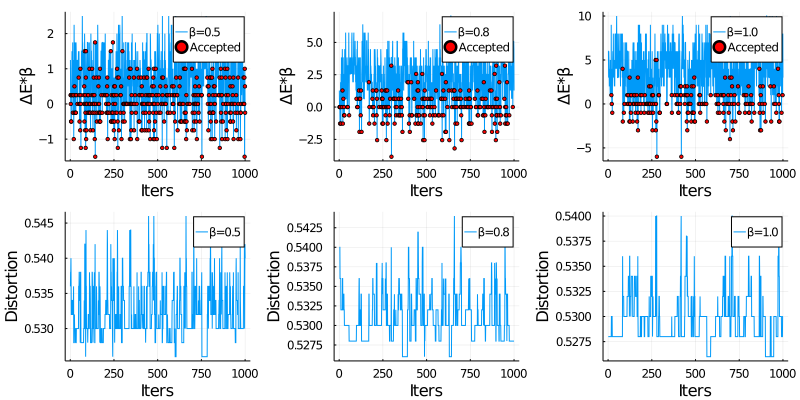

In [95]:
steps = 1:nsamples
pl = [Plots.Plot() for b in 1:2*nbetas]
for b in 1:size(algo.betas,1) 
    pl[b] = plot(steps, dE[b]*beta2[b], label="β=$(beta2[b])", xlabel="Iters", ylabel="ΔE*β")
    scatter!(pl[b], steps[accepted[b]], (dE[b]*beta2[b])[accepted[b]], color=:red, ms=2, label="Accepted")
    pl[b+nbetas] = plot(steps, distortions[b], xlabel="Iters", ylabel="Distortion", label="β=$(beta2[b])")
end
plot(pl..., layout = 2*nbetas, size=(800,400))

### 2. Starting from the 'naive compression' line

In [96]:
q = 2
n = 500
m = 200
b = 5
randseed = 12
lm = LossyModel(q, n, m+b, randseed=randseed)
breduction!(lm, b)
lm

Lossy compression model:
 - Factor Graph with n=500 variables and m=200 factors defined on GF(2)
 - Inverse temperatures β₁=Inf for checks and β₂=1.0 for overlap


In [103]:
beta2 = [.5, .8, 1.]        # overlap temperature for simulated annealing
nbetas = length(beta2)
nsamples = 1000
mc_move = MetropBasisCoeffs()
# Initalize options for SA
betas = hcat(fill(Inf, length(beta2)), beta2)
algo = SA(mc_move=mc_move, nsamples=nsamples, betas = betas)

SA
  mc_move: MetropBasisCoeffs
  betas: Array{Float64}((3, 2)) [Inf 0.5; Inf 0.8; Inf 1.0]
  nsamples: Int64 1000
  sample_every: Int64 1
  stop_crit: crit (function of type var"#crit#200")
  init_state: init (function of type var"#init#201")


In [104]:
# Start on the 'naive compression' line
lm.x = fix_indep_from_src(lm)
# Initialize basis and basis coefficients
adapt_to_model!(algo.mc_move, lm)
# Initalize arrays to store distortion, etc.
distortions = [fill(0.5, algo.nsamples) for _ in 1:size(algo.betas,1)]
accepted = [falses(algo.nsamples) for _ in 1:size(algo.betas,1)]
dE = [zeros(algo.nsamples) for _ in 1:size(algo.betas,1)]
# Loop over betas
for b in 1:nbetas
    # Update temperature
    lm.beta1, lm.beta2 = algo.betas[b,1], algo.betas[b,2]
    # Run MC
    for n in 1:algo.nsamples
        # Return delta energy and whether move was accepted
        accepted[b][n], dE[b][n] = onemcstep!(lm , algo.mc_move, randseed+n) 
        distortions[b][n] = distortion(lm)
    end
end

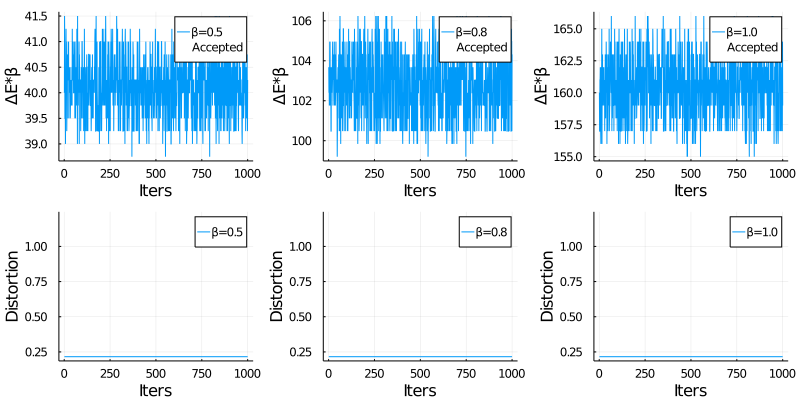

In [105]:
steps = 1:nsamples
pl = [Plots.Plot() for b in 1:2*nbetas]
for b in 1:size(algo.betas,1) 
    pl[b] = plot(steps, dE[b]*beta2[b], label="β=$(beta2[b])", xlabel="Iters", ylabel="ΔE*β")
    scatter!(pl[b], steps[accepted[b]], (dE[b]*beta2[b])[accepted[b]], color=:red, ms=2, label="Accepted")
    pl[b+nbetas] = plot(steps, distortions[b], xlabel="Iters", ylabel="Distortion", label="β=$(beta2[b])")
end
plot(pl..., layout = 2*nbetas, size=(800,400))

## Effect of exposing leaves

In [60]:
q = 2
n = 200
m = 80
bvals = [1, 3, 5, 10, 20, 50, 100]
niter = 200
randseed = 1234;

Cooling schedule for Simulated Annealing: $\beta_{overlap} \in [10^{-1}, 10^0, 10^1]$

In [3]:
sims = Vector{Simulation{SA}}(undef, length(bvals))
algo = SA(mc_move=MetropBasisCoeffs(getbasis=newbasis), nsamples=300, betas=[Inf 0.1; Inf 1.0; Inf 10.0;]);

In [5]:
# time_SA = @timed for (i,b) in enumerate(bvals)
for (i,b) in [(7,bvals[7])]
    println("##### b=$b. $i of $(length(bvals)) #####")
    sims[i] = Simulation(q, n, m, algo, b=b, niter=niter, verbose=true, randseed=randseed+i, showprogress=false)
end

##### b=100. 7 of 7 #####
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.425. Acceptance 90%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.425. Acceptance 44%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.425. Acceptance 5%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter   1 of 200: Parity 0. Distortion 0.425 at β₁=Inf, β₂=0.1. Acceptance: [0.8966666666666666, 0.43666666666666665, 0.05].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.435. Acceptance 93%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.435. Acceptance 51%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.435. Acceptance 4%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter   2 of 200: Parity 0. Distortion 0.435 at β₁=Inf, β₂=0.1. Acceptance: [0.9266666666666666, 0.5066666666666667, 0.043333333333333335].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.495. Acceptance 94%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.495. Acceptance 51%
Temperature 3 of 3:(β₁=Inf,β₂=1

Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.5. Acceptance 90%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.5. Acceptance 45%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.5. Acceptance 3%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter  22 of 200: Parity 0. Distortion 0.500 at β₁=Inf, β₂=0.1. Acceptance: [0.9, 0.4533333333333333, 0.02666666666666667].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.505. Acceptance 92%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.505. Acceptance 42%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.505. Acceptance 1%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter  23 of 200: Parity 0. Distortion 0.505 at β₁=Inf, β₂=0.1. Acceptance: [0.92, 0.42333333333333334, 0.01].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.415. Acceptance 93%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.415. Acceptance 43%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.415. Acceptance 3%
(algo.betas, argmin_beta

Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.48. Acceptance 89%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.48. Acceptance 38%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.48. Acceptance 1%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter  43 of 200: Parity 0. Distortion 0.480 at β₁=Inf, β₂=0.1. Acceptance: [0.8866666666666667, 0.37666666666666665, 0.01].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.415. Acceptance 91%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.415. Acceptance 39%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.415. Acceptance 2%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter  44 of 200: Parity 0. Distortion 0.415 at β₁=Inf, β₂=0.1. Acceptance: [0.91, 0.38666666666666666, 0.02].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.475. Acceptance 90%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.47. Acceptance 44%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.47. Acceptance 4%
(algo.betas, argmin_be

Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.465. Acceptance 91%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.465. Acceptance 50%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.465. Acceptance 2%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter  64 of 200: Parity 0. Distortion 0.465 at β₁=Inf, β₂=0.1. Acceptance: [0.9066666666666666, 0.5, 0.016666666666666666].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.5. Acceptance 91%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.5. Acceptance 43%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.5. Acceptance 0%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter  65 of 200: Parity 0. Distortion 0.500 at β₁=Inf, β₂=0.1. Acceptance: [0.91, 0.43, 0.0033333333333333335].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.47. Acceptance 90%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.47. Acceptance 49%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.47. Acceptance 5%
(algo.betas, argmin_beta

Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.49. Acceptance 91%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.49. Acceptance 38%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.49. Acceptance 6%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter  85 of 200: Parity 0. Distortion 0.490 at β₁=Inf, β₂=0.1. Acceptance: [0.9066666666666666, 0.37666666666666665, 0.06].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.505. Acceptance 92%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.505. Acceptance 51%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.505. Acceptance 7%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter  86 of 200: Parity 0. Distortion 0.505 at β₁=Inf, β₂=0.1. Acceptance: [0.9233333333333333, 0.5066666666666667, 0.06666666666666667].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.475. Acceptance 92%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.475. Acceptance 51%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.475. Accept

Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.44. Acceptance 93%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.44. Acceptance 32%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.44. Acceptance 3%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter 106 of 200: Parity 0. Distortion 0.440 at β₁=Inf, β₂=0.1. Acceptance: [0.9333333333333333, 0.32, 0.03333333333333333].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.46. Acceptance 92%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.46. Acceptance 29%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.46. Acceptance 1%
(algo.betas, argmin_beta) = ([Inf 0.1; Inf 1.0; Inf 10.0], 1)
# Iter 107 of 200: Parity 0. Distortion 0.460 at β₁=Inf, β₂=0.1. Acceptance: [0.92, 0.29, 0.01].
Temperature 1 of 3:(β₁=Inf,β₂=0.1). Distortion 0.535. Acceptance 91%
Temperature 2 of 3:(β₁=Inf,β₂=1.0). Distortion 0.535. Acceptance 35%
Temperature 3 of 3:(β₁=Inf,β₂=10.0). Distortion 0.535. Acceptance 6%
(algo.betas, argmin_beta) = ([Inf 0.1;

LoadError: AssertionError: DEBUG: something's wrong, infinite ΔE in MC move

In [66]:
# sim = Simulation(q, n, m, algo, b=bvals[7], niter=niter, verbose=true, randseed=randseed+7, showprogress=true)
b=bvals[7]
lm = LossyModel(q, n, m+b, beta2=beta2_init(algo), randseed=randseed+7)
it = 112
lm.y .= rand(MersenneTwister(randseed+7+it), 0:q-1, n)
lm.fg = ldpc_graph(q, n, m+b, verbose=false, randseed=randseed+7+it)
breduction!(lm.fg, b, randseed=randseed+7+it)
solve!(lm, algo, randseed=randseed+7+it, verbose=true)

MC running β₁=Inf, β₂=0.1  42%|██████████▌              |  ETA: 0:00:01

LoadError: AssertionError: DEBUG: something's wrong, infinite ΔE in MC move

In [84]:
lm = LossyModel(q, n, m+b, beta2=beta2_init(algo), randseed=randseed+7)
breduction!(lm.fg, b, randseed=randseed+7)
it = 112
lm.y .= rand(MersenneTwister(randseed+7+it), 0:q-1, n)
lm.fg = ldpc_graph(q, n, m+b, verbose=false, randseed=randseed+7+it)
rank(lm)

178

In [88]:
nb = newbasis(lm)
size(nb)
T,c = permute_to_triangular(lm)
size(T)

(177, 200)

In [83]:
# breduction!(lm.fg, 1, randseed=randseed+7)
r = rank(lm)
g = SimpleGraph(full_adjmat(lm.fg))
ncc = length(filter(x->length(x)!=1, connected_components(g)))
@show r, ncc

(r, ncc) = (178, 2)


(178, 2)

In [77]:
g = SimpleGraph(full_adjmat(lm.fg))
# graphplot(g)
filter(x->length(x)!=1, connected_components(g))

45-element Array{Array{Int64,1},1}:
 [6, 28, 122, 160, 205, 276, 283, 285, 313, 364]
 [7, 10, 198, 341, 362]
 [8, 40, 187, 188, 320]
 [9, 179, 204, 225, 230, 326]
 [11, 193, 232]
 [12, 48, 222, 310, 350]
 [16, 240, 324]
 [21, 220, 238]
 [23, 145, 184, 327, 369, 375]
 [24, 62, 63, 98, 102, 114, 131, 143, 177, 192  …  266, 280, 305, 312, 315, 323, 328, 347, 348, 377]
 [29, 254, 267]
 [33, 133, 191, 208, 367]
 [37, 58, 125, 228, 249, 253, 316]
 ⋮
 [115, 219, 257]
 [123, 272, 373]
 [124, 236, 242]
 [129, 288, 301]
 [130, 216, 279]
 [132, 212, 299]
 [136, 199, 260]
 [138, 185, 271]
 [163, 202, 317, 321]
 [172, 270, 330, 357]
 [173, 269, 274, 376]
 [175, 181, 235, 335]

In [7]:
dist = distortion.(sims)
avg_dist = mean.(dist)
sd_dist = std.(dist) ./ sqrt(niter)
pl = Plots.plot(bvals, avg_dist, xlabel="b", ylabel="D", label="", ribbon=sd_dist, marker=:circle)
title!("Distortion vs removed factors - Simulated Annealing")

LoadError: UndefRefError: access to undefined reference